## The aim of this notebook is creating a pipeline to assign to each client the Estimate in the incremental sales uplift caused by an invitation (i.e., the causal effect of the invitation). (CATE) .

- Treatment: Invitation to an event (client_is_invited in Actions).
- Outcome: Post-event sales (e.g., gross_amount_euro in Transactions within a defined window after the event).

In [134]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from econml.grf import CausalForest
from sklearn.model_selection import train_test_split
from dowhy import CausalModel
tqdm.pandas()

In [6]:
# import Data
actions = pd.read_excel("data/actions.xlsx")
clients = pd.read_excel("data/clients.xlsx")
transactions = pd.read_excel("data/transactions.xlsx")

#### Note:
```client_is_invited``` column only contains 1s (i.e., only invited clients are recorded), we lack a control group (clients who were not invited), which is critical for causal inference. Without this, you cannot directly estimate the counterfactual ("What would have happened if they weren't invited?")

In [13]:
print("Number of unique clients invited to events:", actions.client_id.nunique())
print("Number of total potential unique clients:", clients.client_id.nunique())
print("Number of clients who have purchased something:", transactions.client_id.nunique())

Number of unique clients invited to events: 8871
Number of total potential unique clients: 28751
Number of clients who have purchased something: 13884


In [30]:
#clients_not_invited = [client for client in clients.client_id if client not in actions.client_id.unique()]
clients_invited_no_purchase = [client for client in actions.client_id if client not in transactions.client_id.unique()]
len(clients_invited_no_purchase)

4929

Note: We were told to "consider the uplift for the clients that were invited AND that did come to the event. The uplift effect should not be considered for no-shows." so we should condition on coming to the event not on being invited

## Building modelling database: 
We want to build a control group of non-invited clients that are comparable to invited ones
- Active during the event period (e.g., had transactions before/after the event).
- Not invited to other events overlapping in time (to avoid contamination).

In [13]:
grouped_events = actions.groupby([
    'action_id',
    'action_type_label',
    'action_subcategory_label',
    'action_start_date',
    'action_year',
    'action_end_date',
    'action_collection_year',
    'action_collection',
    'action_universe',
    'action_category_label',
    'action_channel',
    'action_label'
]).agg(
    client_is_present_sum=('client_is_present', 'sum'),
    client_is_invited_sum=('client_is_invited', 'sum'),
    unique_client_id_present=('client_id', lambda x: x[actions.loc[x.index, 'client_is_present'] == 1].unique())
).reset_index()

grouped_events.head()

,action_id,action_type_label,action_subcategory_label,action_start_date,action_year,action_end_date,action_collection_year,action_collection,action_universe,action_category_label,action_channel,action_label,client_is_present_sum,client_is_invited_sum,unique_client_id_present
0,a000858,Collection,Collection,2022-02-13,2022,2022-02-15,2022,Summer Collection,Women's Fashion,Retail,In store,Trunk Show Event,76,76,"[c48755642, c46498646, c72007953, c92708610, c..."
1,a005924,Collection,Collection,2022-02-11,2022,2022-02-13,2022,Summer Collection,Women's Fashion,Retail,In store,Exclusive Offer,1,1,[c84447229]
2,a017895,Collection,Collection,2021-02-11,2021,2021-02-15,2021,Summer Collection,Women's Fashion,Retail,Outside venue,Exclusive Offer,1,1,[c84312804]
3,a021005,Collection,Collection,2020-05-07,2020,2020-05-07,2020,Fall Collection,Women's Fashion,Retail,In store,Social Gathering,3,3,"[c33655460, c47834078, c26499328]"
4,a021166,Social Celebrity Action,Collection,2021-12-02,2021,2022-01-01,2021,Retail Action,Women's Fashion,Retail,In store,Holiday Celebration,3,3,"[c10091176, c90950169, c60902832]"


In [48]:
print(f"On average {grouped_events.client_is_invited_sum.mean():.2f} people are invited to an event")
print(f"On average {grouped_events.client_is_present_sum.mean():.2f} people are actually come to an event")

On average 17.99 people are invited to an event
On average 10.53 people are actually come to an event


In [18]:
print("action_type_label: _______________________")
print(grouped_events.action_type_label.value_counts())
print("action_collection: _______________________")
print(grouped_events.action_collection.value_counts())
print("action_universe: _______________________")
print(grouped_events.action_universe.value_counts())
print("action_category_label: _______________________")
print(grouped_events.action_category_label.value_counts())
print("action_channel: _______________________")
print(grouped_events.action_channel.value_counts())
print("action_label: _______________________")
print(grouped_events.action_label.value_counts())


action_type_label: _______________________
action_type_label
Collection                 390
Social Celebrity Action     56
Business Treatment          36
Lauch                        1
Name: count, dtype: int64
action_collection: _______________________
action_collection
Summer Collection                    144
Sailor Collection                     86
Fall Collection                       83
Winter Collection                     71
Retail Action                         57
Spring Collection                     11
Art Collection                         7
Mid-Season Jewelry and Timepieces      6
Spring-Summer Collection               3
Fall-Winter Collection                 3
Lady Collection                        3
Timepieces Collection                  2
Cote d'Azur Collection                 2
Formal Retail Action                   2
Small Jewelry and Timepieces           1
ABCDER Collection                      1
Glamorous Collection                   1
Name: count, dtype: int64
actio

Since we want the CATE for each client but also for a specified event we need to see how many type of event there are. To have enough data for each type of event we might need to generalise the events so we will condition on ```action_universe``` and ```action_category_label```

In [22]:
# Reorder columns to make 'client_id' the second column
columns = actions.columns.tolist()
columns.insert(1, columns.pop(columns.index('client_id')))
actions = actions[columns]

actions = actions.sort_values(by='action_id')

actions.head()

,action_id,client_id,action_type_label,action_subcategory_label,action_start_date,action_year,action_end_date,action_collection_year,action_collection,action_universe,action_category_label,action_channel,action_label,client_is_present,client_is_invited
4354,a000858,c15166949,Collection,Collection,2022-02-13,2022,2022-02-15,2022,Summer Collection,Women's Fashion,Retail,In store,Trunk Show Event,1,1
4404,a000858,c40526451,Collection,Collection,2022-02-13,2022,2022-02-15,2022,Summer Collection,Women's Fashion,Retail,In store,Trunk Show Event,1,1
4403,a000858,c65024960,Collection,Collection,2022-02-13,2022,2022-02-15,2022,Summer Collection,Women's Fashion,Retail,In store,Trunk Show Event,1,1
4402,a000858,c36540867,Collection,Collection,2022-02-13,2022,2022-02-15,2022,Summer Collection,Women's Fashion,Retail,In store,Trunk Show Event,1,1
4401,a000858,c36784244,Collection,Collection,2022-02-13,2022,2022-02-15,2022,Summer Collection,Women's Fashion,Retail,In store,Trunk Show Event,1,1


Assume that actions has been modified with the control clients that havent been invited thanks to clustering

In [31]:
transactions.head()

,client_id,transaction_id,transaction_date,product_quantity,gross_amount_euro,product_category,product_subcategory,product_style
0,c17974679,t11288118,2020-07-25,1,3044,Women Ready-to-Wear,Unknown,Casual Style
1,c17974679,t93389142,2020-06-20,1,569,Women Accessory,Unknown,Stylish Fashion
2,c17974679,t62924895,2021-01-13,1,7727,Women Bags,Unknown,Leather
3,c17974679,t93389142,2020-06-20,1,3954,Women Ready-to-Wear,Unknown,Casual Style
4,c17974679,t33368160,2021-05-03,1,1541,Women Ready-to-Wear,bottom segment,Casual Style


In [35]:
def generalize_product_category(product_category):
    if "Women" in product_category:
        return "Women's Fashion"
    elif "Men" in product_category:
        return "Men's Fashion"
    elif "Jewelry" in product_category or "Watches" in product_category:
        return "Timepieces and Jewelry"
    elif "Child" in product_category:
        return "Infant and Toddler"
    else:
        return "Other"

# Apply the function to create the new column
transactions["generalised_product_category"] = transactions["product_category"].apply(generalize_product_category)

In [37]:
transactions.generalised_product_category.value_counts()

generalised_product_category
Women's Fashion           35285
Other                      8534
Men's Fashion              8493
Infant and Toddler         1696
Timepieces and Jewelry      630
Name: count, dtype: int64

In [38]:
transactions.head()

,client_id,transaction_id,transaction_date,product_quantity,gross_amount_euro,product_category,product_subcategory,product_style,generalised_product_category
0,c17974679,t11288118,2020-07-25,1,3044,Women Ready-to-Wear,Unknown,Casual Style,Women's Fashion
1,c17974679,t93389142,2020-06-20,1,569,Women Accessory,Unknown,Stylish Fashion,Women's Fashion
2,c17974679,t62924895,2021-01-13,1,7727,Women Bags,Unknown,Leather,Women's Fashion
3,c17974679,t93389142,2020-06-20,1,3954,Women Ready-to-Wear,Unknown,Casual Style,Women's Fashion
4,c17974679,t33368160,2021-05-03,1,1541,Women Ready-to-Wear,bottom segment,Casual Style,Women's Fashion


In [185]:
# got a modellign database with clients not invited to use as a control group
df = pd.read_csv("data/event_client.csv")
df.head()

,client_id,Country,Nationality,City,Premium Status,Is Phone Contactable,Is Email Contactable,Is Message Contactable,Category,Sub-Category,...,action_end_date,action_year,action_collection_year,action_collection,action_universe,action_category_label,action_channel,action_label,client_is_present,client_is_invited
0,c00003572,JP,unknown,unknown,0,0,0,0,3,1.0,...,2022-04-11,2022,2022,Mid-Season Jewelry and Timepieces,Timepieces and Jewelry,Retail,In store,Exclusive Offer,0.0,0.0
1,c00003572,JP,unknown,unknown,0,0,0,0,3,1.0,...,2021-10-21,2021,2021,Sailor Collection,Women's Fashion,Retail,In store,Exclusive Offer,0.0,0.0
2,c00003572,JP,unknown,unknown,0,0,0,0,3,1.0,...,2020-10-29,2020,2020,Spring Collection,Men's Fashion,Retail,In store,Social Gathering,0.0,0.0
3,c00003572,JP,unknown,unknown,0,0,0,0,3,1.0,...,2022-01-11,2022,2022,Formal Retail Action,Men's Fashion,Retail,In store,Social Gathering,0.0,0.0
4,c00003572,JP,unknown,unknown,0,0,0,0,3,1.0,...,2021-06-21,2021,2021,Mid-Season Jewelry and Timepieces,Timepieces and Jewelry,Retail,NaN,Exclusive Offer,0.0,0.0


This dataset is huge. We want to filter it so we have the same number of people invited and not invited for each event

In [186]:
# Filter df so that for every action_id there is the same number of people invited as there are not invited.
# Ensure that the people who aren't invited stay in the same category and subcategory as those who are invited.

col_unique_identify_event = ['action_type_label',
       'action_subcategory_label', 'action_start_date', 'action_end_date',
        'action_collection_year', 'action_collection',
       'action_universe',
       'action_label']


# Step 1: Separate invited and not invited clients
invited_df = df[df['client_is_invited'] == 1]
not_invited_df = df[df['client_is_invited'] == 0]

# Step 2: Group by action_id, action_category_label, and action_subcategory_label
grouped_invited = invited_df.groupby([*col_unique_identify_event, 'action_category_label', 'action_subcategory_label'])
grouped_not_invited = not_invited_df.groupby([*col_unique_identify_event, 'action_category_label', 'action_subcategory_label'])

# Step 3: Create a balanced dataframe
balanced_df = pd.DataFrame()

for name, group in grouped_invited:
    *col_unique_identify_event, category, subcategory = name
    invited_count = len(group)
    
    # Get the corresponding not invited group
    not_invited_group = grouped_not_invited.get_group((*col_unique_identify_event, category, subcategory))
    
    # Sample the not invited group to match the number of invited clients
    if len(not_invited_group) >= invited_count:
        sampled_not_invited = not_invited_group.sample(n=invited_count, random_state=42)
    else:
        sampled_not_invited = not_invited_group
    
    # Append to the balanced dataframe
    balanced_df = pd.concat([balanced_df, group, sampled_not_invited])

# Update df with the balanced dataframe
df_1 = balanced_df.reset_index(drop=True)


In [187]:
balanced_df.shape

In [188]:
temp = pd.merge(actions, clients[['client_id', 'client_premium_status']], on="client_id", how='left')

# We want to add to the database hpow much a client spent in the following 30 days after the event, we only
# consider the purchases that aligne with the event so Women's fashion, men's fashion, watchs and jewerly and Children

# Step 1: Merge temp with transactions to access transaction details
temp_with_transactions = pd.merge(temp, transactions, on='client_id', how='left')

# Step 2: Filter transactions within 30 days after action_end_date and matching generalised_product_category
def calculate_gross_spent(row):
    end_date = row['action_end_date']
    category = row['action_universe']
    
    # Filter transactions for the client
    filtered_transactions = temp_with_transactions[
        (temp_with_transactions['client_id'] == row['client_id']) &
        (temp_with_transactions['transaction_date'] > pd.to_datetime(end_date)) &
        (temp_with_transactions['transaction_date'] <= pd.to_datetime(end_date) + pd.DateOffset(days=30)) &
        ((temp_with_transactions['generalised_product_category'] == category) | 
         (temp_with_transactions['generalised_product_category'] == "Other"))
    ]
    
    # Return the sum of gross_amount_euro or 0 if no transactions
    return filtered_transactions['gross_amount_euro'].sum() if not filtered_transactions.empty else 0

# Step 3: Apply the function to calculate gross amount spent
from tqdm import tqdm

# Apply the function with a progress bar
tqdm.pandas()
balanced_df['gross_spend_next_30_days_in_category'] = balanced_df.progress_apply(calculate_gross_spent, axis=1)

100%|██████████| 23188/23188 [02:19<00:00, 166.49it/s]


In [189]:
balanced_df.to_csv("data/modelling_database.csv", index=False)

In [291]:
balanced_df = pd.read_csv("data/modelling_database.csv")
balanced_df.head()

,client_id,Country,Nationality,City,Premium Status,Is Phone Contactable,Is Email Contactable,Is Message Contactable,Category,Sub-Category,...,action_year,action_collection_year,action_collection,action_universe,action_category_label,action_channel,action_label,client_is_present,client_is_invited,gross_spend_next_30_days_in_category
0,c06363783,DE,DEU,WEDEMARK,0,0,0,0,2,2.0,...,2020,2020,Winter Collection,Men's Fashion,Client,Outside venue,Business Engagement,1.0,1.0,0.0
1,c38412787,NO,NOR,TRONDHEIM,0,1,1,1,2,2.0,...,2020,2020,Winter Collection,Men's Fashion,Client,Outside venue,Business Engagement,1.0,1.0,0.0
2,c61328105,unknown,USA,unknown,0,0,0,0,2,1.0,...,2020,2020,Winter Collection,Men's Fashion,Client,Outside venue,Business Engagement,0.0,0.0,0.0
3,c17037470,JP,unknown,unknown,0,0,0,0,3,1.0,...,2020,2020,Winter Collection,Men's Fashion,Client,Outside venue,Business Engagement,0.0,0.0,0.0
4,c02495966,FR,unknown,unknown,0,0,0,1,3,0.0,...,2020,2020,Winter Collection,Women's Fashion,Client,Outside venue,Business Engagement,1.0,1.0,0.0


In [292]:
balanced_df["most_purchased_product_category"] = balanced_df['Most Purchased Product Category'].apply(generalize_product_category)
balanced_df['action_start_date'] = pd.to_datetime(balanced_df['action_start_date'])
balanced_df['Last Purchase Date'] = pd.to_datetime(balanced_df['Last Purchase Date'])
balanced_df['days_since_last_transactions'] = (balanced_df['action_start_date'] - balanced_df['Last Purchase Date']).dt.days

In [293]:
# List of columns to drop
columns_to_drop = [
    'Country', 
    'Nationality', 
    'City', 
    'Most Purchased Product Category',
    'Most Purchased Product Subcategory',
    'Most Purchased Product Style','action_subcategory_label',
    'action_type_label', 'action_collection_year',
    'action_year', 'action_collection',
    'action_channel','action_start_date', 'Last Purchase Date', 'action_end_date',
    'Is Phone Contactable', 'Is Email Contactable','Is Message Contactable']

# Drop the columns from the dataframe
balanced_df.drop(columns=columns_to_drop, inplace=True)

balanced_df['client_is_present'] = balanced_df['client_is_present'].astype(int)
balanced_df['client_is_invited'] = balanced_df['client_is_invited'].astype(int)

balanced_df['days_since_last_transactions'].fillna(5000, inplace=True)


In [294]:
balanced_df['client_is_present'] = balanced_df['client_is_present'].astype(int)
balanced_df['client_is_invited'] = balanced_df['client_is_invited'].astype(int)
balanced_df

,client_id,Premium Status,Category,Sub-Category,Total Past Transactions,Total Past Spending (€),Total Past Products Purchased,action_universe,action_category_label,action_label,client_is_present,client_is_invited,gross_spend_next_30_days_in_category,most_purchased_product_category,days_since_last_transactions
0,c06363783,0,2,2.0,0.0,0.0,0.0,Men's Fashion,Client,Business Engagement,1,1,0.0,Other,5000.0
1,c38412787,0,2,2.0,0.0,0.0,0.0,Men's Fashion,Client,Business Engagement,1,1,0.0,Other,5000.0
2,c61328105,0,2,1.0,2.0,700.0,2.0,Men's Fashion,Client,Business Engagement,0,0,0.0,Women's Fashion,424.0
3,c17037470,0,3,1.0,0.0,0.0,0.0,Men's Fashion,Client,Business Engagement,0,0,0.0,Other,5000.0
4,c02495966,0,3,0.0,0.0,0.0,0.0,Women's Fashion,Client,Business Engagement,1,1,0.0,Other,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23183,c67125448,0,3,0.0,0.0,0.0,0.0,Women's Fashion,Retail,Miscellaneous Social Gathering,0,0,0.0,Other,5000.0
23184,c04753665,0,2,2.0,70.0,113150.0,70.0,Women's Fashion,Retail,Miscellaneous Social Gathering,1,1,0.0,Women's Fashion,189.0
23185,c63777782,0,0,1.0,135.0,391480.0,135.0,Women's Fashion,Retail,Miscellaneous Social Gathering,1,1,0.0,Women's Fashion,103.0
23186,c61318904,0,2,1.0,85.0,182835.0,85.0,Women's Fashion,Retail,Miscellaneous Social Gathering,0,0,0.0,Men's Fashion,76.0


In [296]:
# Generated code ...
# Created/Modified files during execution:
# (No files were created or modified in this example.)

import pandas as pd
#from causalml.inference.tree import XGBTreatmentEffects
from causalml.inference.meta import XGBTRegressor
from sklearn.model_selection import train_test_split

def select_top_clients_for_event(
    df: pd.DataFrame,
    action_category_label_filter="Client",
    action_label_filter="Business Engagement",
    action_universe_filter="Men's Fashion",
    top_n=10
) -> pd.DataFrame:
    """
    Select top N clients with the highest predicted uplift in
    'gross_spend_next_30_days_in_category' if invited to the event.
    """

    # 1. Filter by action labels
    df_event = df[
        (df["action_category_label"] == action_category_label_filter) &
        (df["action_label"] == action_label_filter) &
        (df["action_universe"] == action_universe_filter)
    ].copy()

    # 2. Identify treatment & outcome
    #    'client_is_invited' = w
    #    'gross_spend_next_30_days_in_category' = y
    w = df_event["client_is_invited"]
    y = df_event["gross_spend_next_30_days_in_category"]

    # 3. Prepare features X
    #    We'll encode the categorical columns. Exclude labels, ID, etc. from X.
    feature_cols = [
        "Premium Status",
        "Category",
        "Sub-Category",
        "Total Past Transactions",
        "Total Past Spending (€)",
        "Total Past Products Purchased",
        "client_is_present",
        "days_since_last_transactions"
    ]

    # Optional: One-hot encode these if some are categorical
    # For demonstration, let's do a quick get_dummies on them in one shot
    X = df_event[feature_cols]

    # 4. Train/validation split (not strictly required but recommended for real modeling)
    X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X, y, w, test_size=0.2, random_state=42)

    # 5. Initialize and fit the causal model
    #    NOTE: If you prefer a simpler approach or different library, adapt accordingly.
    #model = XGBTreatmentEffects(random_state=42)
    model = XGBTRegressor(random_state=42)
    model.fit(X_train.values, treatment=w_train, y=y_train)

    # 6. Predict the CATE (uplift) for *all* clients in df_event
    #    We'll pass in the entire df_event (X), in production you might pass out-of-sample data.
    uplift_pred = model.predict(X_val.values).flatten()  # shape: (n_samples,)

    # 7. Attach predicted uplift back to the DataFrame for easy sorting
    df_val = df_event.iloc[X_val.index].copy()
    df_val["predicted_uplift"] = uplift_pred

    # 8. Sort descending by predicted uplift
    df_val_sorted = df_val.sort_values(by="predicted_uplift", ascending=False)

    # 9. Select the top N
    df_top_n = df_val_sorted.head(top_n)

    # Return just the relevant columns, e.g., client_id and predicted uplift
    return df_top_n[["client_id", "predicted_uplift"]]

IndexError: positional indexers are out-of-bounds

In [297]:
# Generated code ...
# Created/Modified files during execution:
# (No files were created or modified in this example.)

import pandas as pd
from causalml.inference.meta import XGBTRegressor  # or another meta-learner of your choice
from sklearn.model_selection import train_test_split

def select_top_clients_for_event(
    df: pd.DataFrame,
    action_category_label_filter="Client",
    action_label_filter="Business Engagement",
    action_universe_filter="Men's Fashion",
    top_n=10
) -> pd.DataFrame:
    """
    Select top N clients with the highest predicted uplift in
    'gross_spend_next_30_days_in_category' if invited.
    Uses a meta-learner approach (XGBTRegressor) from the causalml library.

    Assumes all feature_cols in the list below are numeric.
    """

    # 1. Filter relevant rows by action labels
    df_event = df[
        (df["action_category_label"] == action_category_label_filter) &
        (df["action_label"] == action_label_filter) &
        (df["action_universe"] == action_universe_filter)
    ].copy()

    #
    # 2. Prepare outcome and treatment
    #
    w = df_event["client_is_invited"]  # binary treatment
    y = df_event["gross_spend_next_30_days_in_category"]  # numeric outcome

    #
    # 3. Prepare numeric features (X) as DataFrame
    #
    feature_cols = [
        "Premium Status",
        "Category",
        "Sub-Category",
        "Total Past Transactions",
        "Total Past Spending (€)",
        "Total Past Products Purchased",
        "client_is_present",
        "days_since_last_transactions"
    ]
    X = df_event[feature_cols]  # all numeric, no one-hot encoding needed

    #
    # 4. Train/Test Split on the DataFrame directly
    #
    X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
        X, y, w, test_size=0.2, random_state=42
    )

    #
    # 5. Fit a Causal ML meta-learner model (XGBTRegressor)
    #
    model = XGBTRegressor(random_state=42)
    model.fit(X_train, treatment=w_train, y=y_train)

    #
    # 6. Predict the uplift (CATE) on the validation set
    #
    uplift_pred = model.predict(X_val)

    #
    # 7. Attach the predictions to the corresponding subset
    #    Use .loc[] so our row indices match X_val's
    #
    df_val = df_event.loc[X_val.index].copy()
    df_val["predicted_uplift"] = uplift_pred

    #
    # 8. Sort descending by predicted uplift & pick the top_n
    #
    df_val_sorted = df_val.sort_values(by="predicted_uplift", ascending=False)
    df_top_n = df_val_sorted.head(top_n)

    #
    # 9. Return relevant columns (e.g., client_id and predicted_uplift)
    #
    return df_top_n[["client_id", "predicted_uplift"]]

In [303]:
balanced_df.action_label.value_counts()

action_label
Social Gathering                  7958
Exclusive Offer                   7534
Holiday Celebration               3486
Trunk Show Event                  1248
Lunar New Year Celebration        1234
Outdoor Event                      888
Miscellaneous Social Gathering     370
Business Engagement                184
Luxurious Fur Showcase             166
Exclusive Client Days               38
Back-to-School Promotion            30
Exclusive Preview                   22
Fur Collection Rotation             10
Live Presentation                    8
Internet Event                       6
Special Tailored Service             4
VIP Opening Days                     2
Name: count, dtype: int64

In [306]:
select_top_clients_for_event(balanced_df,action_category_label_filter="Retail",
    action_label_filter="Social Gathering",
    action_universe_filter="Men's Fashion",
    top_n=25)

,client_id,predicted_uplift
7402,c61575131,9256.132812
7585,c52140966,3994.912842
11716,c29381926,3339.106445
7596,c96685101,2735.249756
7369,c31713903,2267.805176
15925,c86781558,2063.250977
7374,c49666160,1717.472778
7115,c90400147,1620.565186
9090,c54870615,1232.296875
9068,c47367452,1185.207031


In [281]:
balanced_df.columns

Index(['client_id', 'Premium Status', 'Category', 'Sub-Category',
       'Total Past Transactions', 'Total Past Spending (€)',
       'Total Past Products Purchased', 'action_universe',
       'action_category_label', 'action_label', 'client_is_present',
       'client_is_invited', 'gross_spend_next_30_days_in_category'],
      dtype='object')

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [307]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def train_t_learner(df):
    """
    Trains two separate models: one for T=1, one for T=0.
    Returns the trained models and a function to compute uplift.
    """
    # Define outcome, treatment, features
    Y = df['gross_spend_next_30_days_in_category'].values
    T = df['client_is_present'].values

    # Columns we do NOT want in X
    cols_to_exclude = [
        'client_id',
        'client_is_invited',
        'client_is_present',
        'gross_spend_next_30_days_in_category'
    ]

    # X includes everything else
    X_cols = [col for col in df.columns if col not in cols_to_exclude]
    X = df[X_cols]

    # One-hot encode categorical columns (if you haven't already)
    X_encoded = pd.get_dummies(X, drop_first=True)

    # Split data for training/tuning (optional)
    X_train, X_val, Y_train, Y_val, T_train, T_val = train_test_split(
        X_encoded, Y, T, test_size=0.2, random_state=42
    )

    # Model for treated (T=1)
    model_treated = RandomForestRegressor(n_estimators=100, random_state=42)
    model_treated.fit(X_train[T_train == 1], Y_train[T_train == 1])

    # Model for control (T=0)
    model_control = RandomForestRegressor(n_estimators=100, random_state=42)
    model_control.fit(X_train[T_train == 0], Y_train[T_train == 0])

    # A simple function to get predicted uplift:
    def predict_uplift(x_df):
        """
        x_df: a DataFrame of features (one-hot-encoded in the same way as X_encoded).
        Returns: array of predicted incremental uplift = Yhat(T=1) - Yhat(T=0).
        """
        yhat_t1 = model_treated.predict(x_df)
        yhat_t0 = model_control.predict(x_df)
        return yhat_t1 - yhat_t0

    return model_treated, model_control, X_encoded.columns, predict_uplift

In [308]:
def recommend_clients_for_event(
    df,
    feature_cols,
    predict_uplift_func,
    action_label="Business Engagement",
    action_category_label="Client",
    action_universe="Men's Fashion",
    top_n=10
):
    """
    Given a new event context, returns the top_n clients by predicted uplift.
    """
    # 1) Filter the dataset to clients who are *eligible* to invite
    #    For example, let's say we consider clients who are not already present.
    #    Or you might define your own logic (e.g. not in T=1 from the same event).

    # Example: filter the entire dataset by these event columns
    # If each row represents a (client, event) combination:
    df_event = df.loc[
        (df['action_label'] == action_label) &
        (df['action_category_label'] == action_category_label) &
        (df['action_universe'] == action_universe)
    ].copy()

    # We might also want to consider only those who were NOT present (control group),
    # or those not invited, etc. Depending on your use case:
    # df_event = df_event[df_event['client_is_present'] == 0]

    if df_event.empty:
        print("No clients found matching the specified event context.")
        return pd.DataFrame()

    # 2) Prepare the same feature transformation (one-hot) used during training
    #    We'll replicate the columns (feature_cols) to ensure consistent encoding
    X_new = df_event.drop(
        columns=['client_id','client_is_present','client_is_invited','gross_spend_next_30_days_in_category'],
        errors='ignore'
    )
    X_new_encoded = pd.get_dummies(X_new, drop_first=True)

    # Align columns with the training feature space (fill missing with 0 if the new dataset doesn’t have certain dummies)
    X_new_encoded = X_new_encoded.reindex(columns=feature_cols, fill_value=0)

    # 3) Compute predicted uplift
    df_event['predicted_uplift'] = predict_uplift_func(X_new_encoded)

    # 4) Sort by uplift and select top_n
    df_event = df_event.sort_values(by='predicted_uplift', ascending=False)
    top_clients = df_event.head(top_n)

    return top_clients[['client_id', 'predicted_uplift']]

In [309]:
# ===========================
#  Example Usage
# ===========================


# STEP A: Train the T-Learner on the historical data
model_treated, model_control, feature_cols, predict_uplift = train_t_learner(balanced_df)

# STEP B: Call the recommendation function for the new (hypothetical) event
top_10 = recommend_clients_for_event(
    df=balanced_df,
    model_treated=model_treated,
    model_control=model_control,
    feature_cols=feature_cols,
    predict_uplift_func=predict_uplift,
    action_label="Social Gathering",
    action_category_label="Retail",
    action_universe="Men's Fashion",
    top_n=25
)

print("Top 10 clients to invite:")
print(top_10)

Top 10 clients to invite:
       client_id  predicted_uplift
11715  c25395020      21372.505000
9057   c04689514      12857.490000
9066   c37193690      10741.710000
7595   c89762775      10587.576190
7388   c78265491       9744.650000
7592   c69731635       9663.666190
7578   c06393729       8910.198000
14716  c06811370       8237.520000
7587   c55637984       8063.000000
11712  c06288546       7955.502857
9083   c91877336       7798.140000
7358   c08644510       6553.733702
9073   c58601014       6332.345714
7598   c82558461       6315.482857
11716  c29381926       6172.374190
7409   c99254830       5940.010000
9087   c97007787       5917.977000
9074   c61375656       5658.512857
7362   c14466669       5537.880000
9060   c10568173       5176.110000
9062   c12598994       4909.510000
7591   c69699720       4416.360857
10885  c67357526       4284.850000
9076   c73901243       3925.226667
7416   c43036684       3690.060000


# Final and best Version !!!!!!!!!!!!!!!!!!!!!!!!!!!

In [358]:
balanced_df.to_csv('final_modelling_database.csv', index=False)

In [356]:
import pandas as pd
import matplotlib.pyplot as plt
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor

def get_top_clients_to_invite(df, action_label="Business Engagement",
                            action_category_label="Client", 
                            action_universe="Men's Fashion"):
    """Main function to process data and calculate uplift"""
    df = df.copy()
    
    # 1. Create treatment indicator
    treatment_condition = (
        (df['action_category_label'] == action_category_label) & 
        (df['action_label'] == action_label) & 
        (df['action_universe'] == action_universe)
    )
    df['T'] = treatment_condition.astype(int)
    
    # 2. Encode categorical features
    df = pd.get_dummies(df, columns=['most_purchased_product_category'])
    
    # 3. Define confounders (features affecting both treatment and outcome)
    confounders = [
        'Premium Status', 'Category', 'Sub-Category',
        'Total Past Transactions', 'Total Past Spending (€)',
        'Total Past Products Purchased', 'days_since_last_transactions'
    ] + list(df.filter(like='most_purchased_product_category_').columns)
    
    # 4. Initialize and train causal model
    estimator = CausalForestDML(
        model_y=RandomForestRegressor(n_estimators=200),
        model_t=RandomForestRegressor(n_estimators=200),
        n_estimators=500
    )
    estimator.fit(
        Y=df['gross_spend_next_30_days_in_category'],  # Outcome
        T=df['T'],  # Treatment
        X=df[confounders]  # Features
    )
    
    # 5. Calculate uplift for all clients
    df['uplift'] = estimator.effect(df[confounders])
    
    return df, estimator, confounders


Average Treatment Effect: €997.21 ± €0.00 (95% CI)


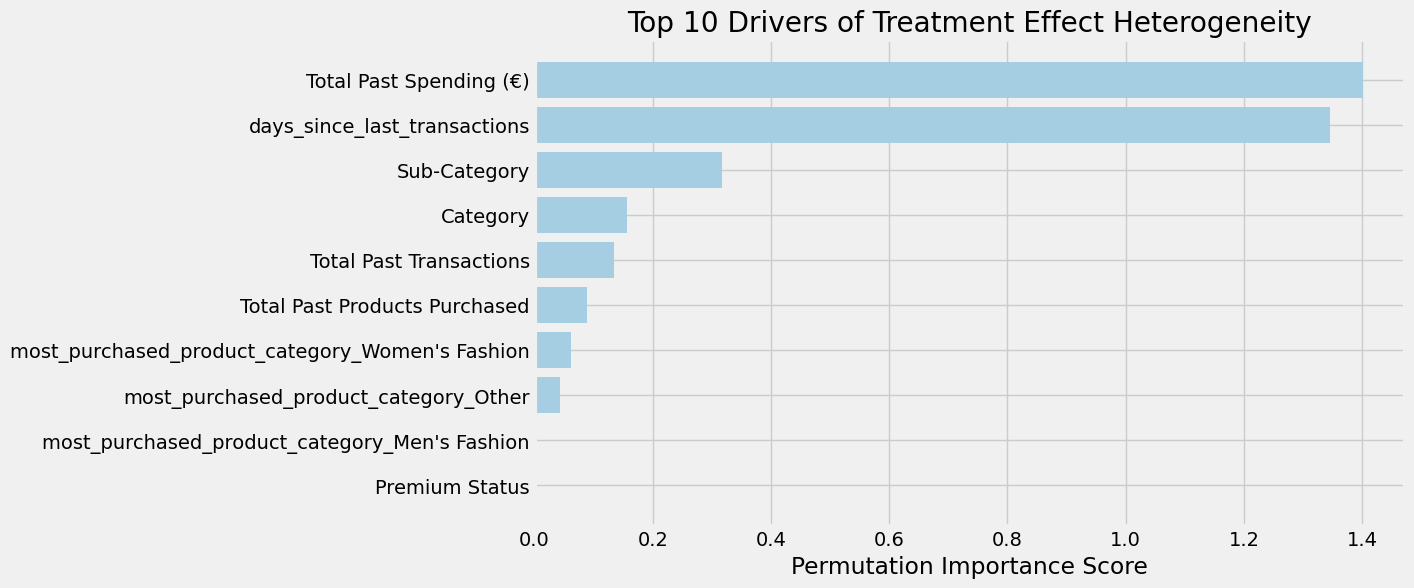

Top Clients to Invite:
       client_id     uplift
22055  c15360348  312082.51
23185  c63777782  243561.48
16010  c85425409  235606.21
16090  c85425409  235606.21
16170  c85425409  235606.21
16250  c85425409  235606.21
16330  c85425409  235606.21
22056  c25635348  191607.71
18052  c03877908  186031.66
18058  c03877908  186031.66


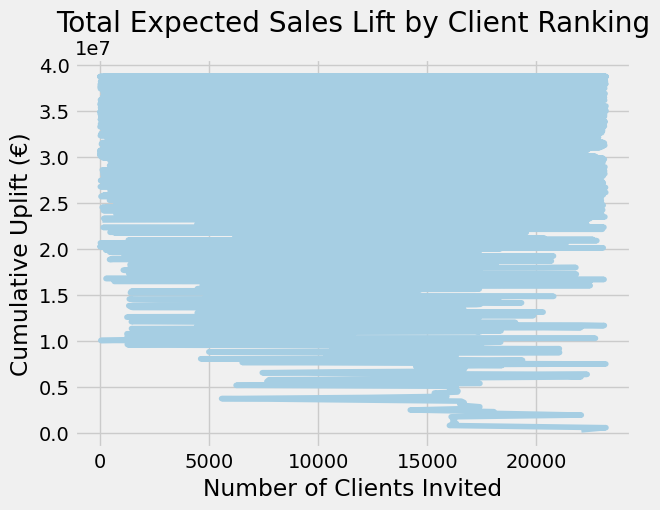

In [357]:
# 1. Get predictions
processed_df, model, confounders = get_top_clients_to_invite(balanced_df)

# 2. Validate model (now works with correct imports)
validate_model(processed_df, model, confounders)

# 3. Show top clients
top_clients = processed_df.nlargest(10, 'uplift')[['client_id', 'uplift']]
print("Top Clients to Invite:")
print(top_clients.round(2))

# 4. Plot cumulative uplift
processed_df.sort_values('uplift', ascending=False)['uplift'].cumsum().plot()
plt.title('Total Expected Sales Lift by Client Ranking')
plt.xlabel('Number of Clients Invited')
plt.ylabel('Cumulative Uplift (€)')
plt.show()